In [1]:
from torchcrf import CRF
import torch
import spacy
import pandas as pd
import torch.nn as nn
from torch_optimizer import Lookahead
from torch.optim import RAdam, NAdam
import torch.nn.functional as F
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, TensorDataset, random_split
from metrics import f1score
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from multiprocessing import cpu_count
from platform import system
from os import environ
from sklearn.metrics import classification_report
from pandas import read_csv
import numpy as np
from itertools import chain
from utils import post_pad_sequences
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot as plt
from collections import Counter

environ["TOKENIZERS_PARALLELISM"] = "false"
nlp = spacy.load("en_core_web_sm")
pl.seed_everything(seed=42)

c:\Users\gumma\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\utilities\apply_func.py:41: UserWarning: Failed to initialize NumPy: module compiled against API version 0x10 but this version of numpy is 0xf (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:68.)
  _CPU_DEVICES = ("cpu", torch.device("cpu"))
Global seed set to 42


42

In [2]:
LEARNING_RATE = 5e-3
BATCH_SIZE = 128
EPOCHS = 128
MAX_LEN = None
WEIGHT_DECAY = 1e-2
N_JOBS = cpu_count() if system() != "Windows" else 0

tag2idx = {'B': 0, 'I': 1, 'O': 2, 'E': 3, 'S': 4, '<': 5, ">":6, "$": 7}
pos2idx = {"NOUN": 0, "PROPN": 1, "VERB": 2, "ADJ": 3, "OTHER": 4, "<START>": 5, "<END>": 6, "<PAD>": 7}

In [3]:
class CRF4NER(pl.LightningModule):
    def __init__(self, 
                 num_tags=len(tag2idx),
                 train_dataset=None,
                 val_dataset=None,
                 test_dataset=None):

        super().__init__()
        self.crf = CRF(num_tags=num_tags,
                       batch_first=True)
        
        ## Hyperparameters ##
        self.batch_size = BATCH_SIZE
        self.learning_rate = LEARNING_RATE
        self.weight_decay = WEIGHT_DECAY
        ## Datasets ##
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.test_dataset = test_dataset

    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, 
                          batch_size=self.batch_size,
                          shuffle=True,
                          num_workers=N_JOBS,
                          drop_last=False)


    def val_dataloader(self):
        return DataLoader(self.val_dataset, 
                          batch_size=self.batch_size,
                          num_workers=N_JOBS,
                          drop_last=False)


    def test_dataloader(self):
        return DataLoader(self.test_dataset, 
                          batch_size=self.batch_size,
                          num_workers=N_JOBS,
                          drop_last=False)

    
    def predict_dataloader(self):
        return DataLoader(self.test_dataset, 
                          batch_size=self.batch_size,
                          num_workers=N_JOBS,
                          drop_last=False)
        
        
    def forward(self, input_ids):
        pass


    def _shared_evaluation_step(self, batch, batch_idx):
        ids, masks, lbls = batch
        loss = -self.crf(ids, lbls, masks)
        pred = self.crf.decode(ids, masks)
        r, p, f1 = f1score(lbls.tolist(), pred)
        return loss, r, p, f1
    
        
    def training_step(self, batch, batch_idx):
        loss, r, p, f1 = self._shared_evaluation_step(batch, batch_idx)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train_recall", r, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train_precision", p, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train_f1score", f1, on_step=False, on_epoch=True, prog_bar=True)
        return loss


    def validation_step(self, batch, batch_idx):
        loss, r, p, f1 = self._shared_evaluation_step(batch, batch_idx)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_recall", r, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_precision", p, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_f1score", f1, on_step=False, on_epoch=True, prog_bar=True)

    
    def test_step(self, batch, batch_idx):
        loss, r, p, f1 = self._shared_evaluation_step(batch, batch_idx)
        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("test_recall", r, on_step=False, on_epoch=True, prog_bar=True)
        self.log("test_precision", p, on_step=False, on_epoch=True, prog_bar=True)
        self.log("test_f1score", f1, on_step=False, on_epoch=True, prog_bar=True)


    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        ids, masks, _ = batch 
        return self.crf.decode(ids, mask=masks)


    def configure_optimizers(self):
        optimizer = NAdam(self.parameters(), 
                          lr=self.learning_rate,
                          weight_decay=self.weight_decay)

        return [optimizer]

number of sentences with atleast one feature: 1252 [0.5725]
Counter({'O': 19652, 'B': 1409, 'E': 1394, 'S': 1189, 'I': 382})


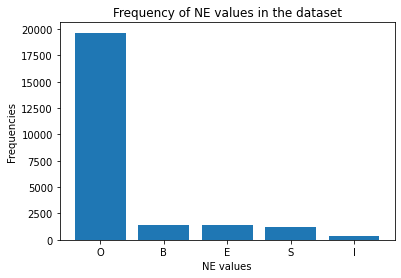

In [4]:
data = pd.read_csv("../data/train_290818.txt", 
                   sep=' ',
                   header=None,
                   names=['a', 'b', 'c'],
                   encoding="utf-8",
                   converters={'a': pd.eval, 
                               'b': pd.eval})

all_samples = len(data)
data = data[data['c'] > 0]

text = [[token.pos_ for token in nlp(' '.join(s))] for s in data['a']]
text = [[p if (p == "NOUN" or p == "PROPN" or p == "VERB" or p == "ADJ") else "OTHER" for p in sent] for sent in text]
text = post_pad_sequences(text, maxlen=MAX_LEN, return_masks=True)

encoded_input = np.array([to_categorical([pos2idx[p] for p in sent], 
                                         num_classes=len(tag2idx), 
                                         dtype="int32") for sent in text["seq"]])

labels = [[l.split('-')[0] for l in labels] for labels in data['b']]

#################################################################################################################
print(f"number of sentences with atleast one feature: {len(data)} [{len(data)/all_samples:.4f}]")

temp_data = Counter(list(chain.from_iterable(labels)))
print(temp_data)
feats = temp_data.keys()
freq = temp_data.values()
plt.bar(feats, freq)
plt.xlabel("NE values")
plt.ylabel("Frequencies")
plt.title("Frequency of NE values in the dataset")
plt.show()
#################################################################################################################

labels = post_pad_sequences(labels, maxlen=MAX_LEN, return_masks=False, start='<', end='>', pad='$')["seq"]
labels = [[tag2idx[l] for l in lbls] for lbls in labels]

dataset = TensorDataset(torch.LongTensor(encoded_input),
                        torch.BoolTensor(text["mask"]),
                        torch.LongTensor(labels))

train_sz, val_sz = len(labels)-int(0.1*len(labels)), int(0.1*len(labels))
train_dataset, val_dataset = random_split(dataset, (train_sz, val_sz)) 

In [5]:
data = pd.read_csv("../data/train_290818.txt", 
                   sep=' ',
                   header=None,
                   names=['a', 'b', 'c'],
                   encoding="utf-8",
                   converters={'a': pd.eval, 
                               'b': pd.eval})

data = data[data['c'] > 0]

text = [[token.pos_ for token in nlp(' '.join(s))] for s in data['a']]
text = [[p if (p == "NOUN" or p == "PROPN" or p == "VERB" or p == "ADJ") else "OTHER" for p in sent] for sent in text]
text = post_pad_sequences(text, maxlen=MAX_LEN, return_masks=True)
encoded_input = np.array([to_categorical([pos2idx[p] for p in sent], 
                                         num_classes=len(tag2idx), 
                                         dtype="int32") for sent in text["seq"]])

labels = [[l.split('-')[0] for l in labels] for labels in data['b']]
labels = post_pad_sequences(labels, maxlen=MAX_LEN, return_masks=False, start='<', end='>', pad='$')
labels = [[tag2idx[l] for l in lbls] for lbls in labels["seq"]]

test_dataset = TensorDataset(torch.LongTensor(encoded_input),
                             torch.BoolTensor(text["mask"]),
                             torch.LongTensor(labels))                                                             

In [6]:
model = CRF4NER(train_dataset=train_dataset,
                val_dataset=val_dataset,
                test_dataset=test_dataset)

earlystopping_callback = EarlyStopping(monitor="val_f1score", 
                                       min_delta=1e-4, 
                                       patience=EPOCHS, 
                                       mode="max")

checkpoint_callback = ModelCheckpoint(dirpath="./",
                                      filename="crf-ner-val-f1score",
                                      save_top_k=1, 
                                      mode="max",
                                      monitor="val_f1score",
                                      save_weights_only=True)

trainer = pl.Trainer(accelerator="gpu",
                     max_epochs=EPOCHS,
                     precision=16,
                     log_every_n_steps=1,
                     callbacks=[earlystopping_callback, checkpoint_callback])

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [7]:
trainer.fit(model)

Missing logger folder: D:\Suggestion-Mining-from-Noisy-Data\src_feat\lightning_logs
C:\Users\gumma\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:611: UserWarning: Checkpoint directory D:\Suggestion-Mining-from-Noisy-Data\src_feat exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type | Params
------------------------------
0 | crf  | CRF  | 80    
------------------------------
80        Trainable params
0         Non-trainable params
80        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\gumma\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\gumma\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

C:\Users\gumma\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [8]:
model.load_state_dict(torch.load(f"./crf-ner-val-f1score.ckpt")["state_dict"])
trainer.test(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\gumma\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

In [9]:
preds = list(chain.from_iterable(trainer.predict(model)))

preds = post_pad_sequences(preds,
                           start=tag2idx['<'], 
                           end=tag2idx['>'], 
                           pad=tag2idx['$'],
                           maxlen=len(labels[0]),
                           return_masks=False)["seq"]


preds = np.array(preds).flatten()                        
lbls = np.array(labels).flatten()

clf_rp = classification_report(lbls,
                               preds,
                               zero_division=0,
                               labels=[0, 1, 2, 3, 4, 5, 6, 7],
                               target_names=['B', 'I', 'O', 'E', 'S', 'START (<)', 'END (>)', 'PAD ($)'])

print("-"*80)
print(clf_rp)
print("-"*80)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\gumma\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 7it [00:00, ?it/s]


KeyboardInterrupt

